# Install and import the required libraries

In [1]:
%%time
!pip install -q -q -r requirements.txt

CPU times: user 28.1 ms, sys: 10.6 ms, total: 38.8 ms
Wall time: 1.5 s


In [2]:
import pandas as pd
from genaishap import Featurizer, GenAIExplainer
import matplotlib.pyplot as plt
import shap
from IPython.display import Markdown, display

In [3]:
shap.initjs()

# Prepare the dataset

## Some definitions:

* **Context prescision:** Measures how much of the generated output is relevant and aligns with the context provided in the input.
* **Context recall:** Measures how much of the relevant information in the input context is included in the output.
* **Faithfulness:** Measures how accurate and truthful the generated output is in relation to the input context and factual correctness. Faithfulness is about avoiding "hallucinations" (made-up or false information).

In [4]:
df_test_dataset = pd.read_json('./test-dataset.json', orient='records')
df_test_dataset

,user_input,retrieved_contexts,response,reference,faithfulness,context_precision,context_recall
0,Can you provide for me the three highlights fo...,"[31. In 2018, to align with industry best prac...",The three highlights for the GHG emissions sec...,"Sure, they are: \n1. 65% cumulative GHG emissi...",1.000000,0.0,0.000000
1,What percentage of waste from Google's offices...,[Performance highlights\nThe following section...,"In 2021, 78% of waste from Google's global dat...",Sixty-four percent.,1.000000,0.0,0.000000
2,Can you present me with the performance highli...,"[Education\nFor more than 40 years, we’ve work...",The performance highlights for empowering user...,Sure! The Performance Highlights for Empowerin...,1.000000,0.0,0.000000
3,What was the listed key achievement regarding ...,[Our approach\nWe believe that every business ...,There is no listed key achievement for Google ...,"In 2017, Google became the first major company...",1.000000,1.0,1.000000
4,Did Google reach its intended Waste target und...,[BUILDING BETTER DEVICES AND SERVICES\nTarget ...,"Yes, in 2021, Google achieved the UL 2799 Zero...","No, this target has not been met in 2021. Howe...",0.666667,1.0,1.000000
5,How many EV charging locations were there on G...,[This guidance does not recognize existing ren...,The provided context does not specify the numb...,200000,1.000000,0.0,0.000000
6,On what page of the report can I find the perf...,"[Employee Recruitment, Inclusion and Performan...",The performance highlights for the Empowering ...,The performance highlights for Empowering User...,0.000000,0.0,0.000000
7,Can you please provide for me the glossary of ...,[GRI INDEX\nGRI 304 - Biodiversity\nGRI 103 Ma...,I'm unable to provide the glossary of the docu...,"Sure, here is the glossary:\nGlossary\nCFE: ca...",0.500000,0.0,0.000000
8,On what page can I find details about Amazons ...,[IntroductionSustainability\nDriving Climate S...,You can find details about Amazon's climate so...,You can find information on driving climate so...,0.000000,0.0,0.000000
9,"For the listed Renewable Energy goals, by when...",[IntroductionSustainability\nDriving Climate S...,Amazon intends to have all operations powered ...,Amazon set the goal of becoming powered by 100...,1.000000,1.0,0.000000


# Extract features from the questions in the dataset

In [5]:
%%time

# The Featurizer is part of the DS Toolkit and is able to take the list of provided questions and create a dataset of features for them automatically.
featurizer = Featurizer.from_pandas(df_test_dataset)
featurizer.create_features_using_azure_openai(
    deployment_name="gpt-4o", # Update with the name of your Azure OpenAI LLM deployment name
    num_features=12
)
print(featurizer.features.model_dump_json(indent=4))

{
    "features": [
        {
            "feature": "there_is_any_company_identified_in_the_question",
            "ftype": "boolean"
        },
        {
            "feature": "list_of_companies_identified_in_the_question",
            "ftype": "list_of_strings"
        },
        {
            "feature": "there_is_any_initiative_or_program_identified_in_the_question",
            "ftype": "boolean"
        },
        {
            "feature": "list_of_initiatives_or_programs_identified_in_the_question",
            "ftype": "list_of_strings"
        },
        {
            "feature": "there_is_any_financial_or_environmental_metric_identified_in_the_question",
            "ftype": "boolean"
        },
        {
            "feature": "list_of_financial_or_environmental_metrics_identified_in_the_question",
            "ftype": "list_of_strings"
        },
        {
            "feature": "there_is_any_specific_year_identified_in_the_question",
            "ftype": "boolean"
        }

In [6]:
%%time

featurizer.fill_out_features_using_azure_openai(
    deployment_name="gpt-4o", 
    batch_size=20
)

  0%|          | 0/3 [00:00<?, ?it/s]

CPU times: user 78.9 ms, sys: 3.75 ms, total: 82.6 ms
Wall time: 2min 38s


/home/jupyter-ricastro1/.local/lib/python3.12/site-packages/genaishap/featurize.py:252: UserWarning: There are differences in some question input and output review the version of the language model, try to use a bigger model >=gpt-4o.  The differences are: 
QIN: What was the listed key achievement regarding sustainbility and climate change for Google in 2077?
QOU: What was the listed key achievement regarding sustainability and climate change for Google in 2077?

QIN: What were Amazon's Carbon Intesity values in (C02e per $ of GMS) in the years 2019 to 2022?
QOU: What were Amazon's Carbon Intensity values in (C02e per $ of GMS) in the years 2019 to 2022?

  warnings.warn(message)


In [7]:
df_features = featurizer.to_pandas()
df_test_dataset.join(df_features)

,user_input,retrieved_contexts,response,reference,faithfulness,context_precision,context_recall,there_is_any_company_identified_in_the_question,list_of_companies_identified_in_the_question,there_is_any_initiative_or_program_identified_in_the_question,list_of_initiatives_or_programs_identified_in_the_question,there_is_any_financial_or_environmental_metric_identified_in_the_question,list_of_financial_or_environmental_metrics_identified_in_the_question,there_is_any_specific_year_identified_in_the_question,list_of_years_identified_in_the_question,is_a_question_about_trends_or_changes_over_time,is_a_question_about_identification_of_factors_or_insights,is_a_question_related_to_a_specific_page_or_section_of_a_document,is_a_question_about_goals_or_targets
0,Can you provide for me the three highlights fo...,"[31. In 2018, to align with industry best prac...",The three highlights for the GHG emissions sec...,"Sure, they are: \n1. 65% cumulative GHG emissi...",1.000000,0.0,0.000000,False,[],True,[Advancing Carbon-Free Energy],True,[GHG emissions],False,[],False,True,True,False
1,What percentage of waste from Google's offices...,[Performance highlights\nThe following section...,"In 2021, 78% of waste from Google's global dat...",Sixty-four percent.,1.000000,0.0,0.000000,True,[Google],False,[],True,[waste diversion],True,[2021],False,False,False,False
2,Can you present me with the performance highli...,"[Education\nFor more than 40 years, we’ve work...",The performance highlights for empowering user...,Sure! The Performance Highlights for Empowerin...,1.000000,0.0,0.000000,False,[],True,[Empowering Users With Technology],False,[],False,[],False,True,True,False
3,What was the listed key achievement regarding ...,[Our approach\nWe believe that every business ...,There is no listed key achievement for Google ...,"In 2017, Google became the first major company...",1.000000,1.0,1.000000,True,[Google],False,[],False,[],True,[2077],False,True,False,False
4,Did Google reach its intended Waste target und...,[BUILDING BETTER DEVICES AND SERVICES\nTarget ...,"Yes, in 2021, Google achieved the UL 2799 Zero...","No, this target has not been met in 2021. Howe...",0.666667,1.0,1.000000,True,[Google],True,[Building Better Devices and Services],True,[waste target],True,[2021],False,False,False,True
5,How many EV charging locations were there on G...,[This guidance does not recognize existing ren...,The provided context does not specify the numb...,200000,1.000000,0.0,0.000000,True,[Google],False,[],True,[EV charging locations],True,[2021],False,False,False,False
6,On what page of the report can I find the perf...,"[Employee Recruitment, Inclusion and Performan...",The performance highlights for the Empowering ...,The performance highlights for Empowering User...,0.000000,0.0,0.000000,False,[],True,[Empowering Users With Technology],False,[],False,[],False,False,True,False
7,Can you please provide for me the glossary of ...,[GRI INDEX\nGRI 304 - Biodiversity\nGRI 103 Ma...,I'm unable to provide the glossary of the docu...,"Sure, here is the glossary:\nGlossary\nCFE: ca...",0.500000,0.0,0.000000,False,[],False,[],False,[],False,[],False,False,True,False
8,On what page can I find details about Amazons ...,[IntroductionSustainability\nDriving Climate S...,You can find details about Amazon's climate so...,You can find information on driving climate so...,0.000000,0.0,0.000000,True,[Amazon],False,[],False,[],False,[],False,False,True,False
9,"For the listed Renewable Energy goals, by when...",[IntroductionSustainability\nDriving Climate S...,Amazon intends to have all operations powered ...,Amazon set the goal of becoming powered by 100...,1.000000,1.0,0.000000,True,[Amazon],False,[],True,[renewable energy],False,[],False,False,False,True


# Fit models for the selected metrics using the features generated and produce explanations using SHAP

In [8]:
genai_explainer = GenAIExplainer.from_pandas(df_test_dataset, df_features)
genai_explainer.feature_engineering()
genai_explainer.create_explainers()

Metric loop:   0%|          | 0/3 [00:00<?, ?it/s]

faithfulness:   0%|          | 0/3 [00:00<?, ?it/s]

/home/jupyter-ricastro1/.local/lib/python3.12/site-packages/genaishap/explainer.py:281: UserWarning: The best estimator for metric faithfulness is producing results that differs significantly with respect to the original metrics. This could lead to produce misleading explanations. Please change the features used to train the black-box model.
  warnings.warn(
/home/jupyter-ricastro1/.local/lib/python3.12/site-packages/genaishap/explainer.py:298: UserWarning: There are 9 estimated values in the metric faithfulness far from the original values. The following is the list of indexes [13, 14, 24, 25, 26, 27, 36, 37, 40].
  warnings.warn(


context_precision:   0%|          | 0/3 [00:00<?, ?it/s]

/home/jupyter-ricastro1/.local/lib/python3.12/site-packages/genaishap/explainer.py:298: UserWarning: There are 4 estimated values in the metric context_precision far from the original values. The following is the list of indexes [24, 25, 26, 41].
  warnings.warn(


context_recall:   0%|          | 0/3 [00:00<?, ?it/s]

/home/jupyter-ricastro1/.local/lib/python3.12/site-packages/genaishap/explainer.py:298: UserWarning: There are 6 estimated values in the metric context_recall far from the original values. The following is the list of indexes [23, 24, 25, 26, 27, 41].
  warnings.warn(


In [9]:
genai_explainer.r2_scores_

{'faithfulness': 0.638837988948777,
 'context_precision': 0.846161847818857,
 'context_recall': 0.7971689035813322}

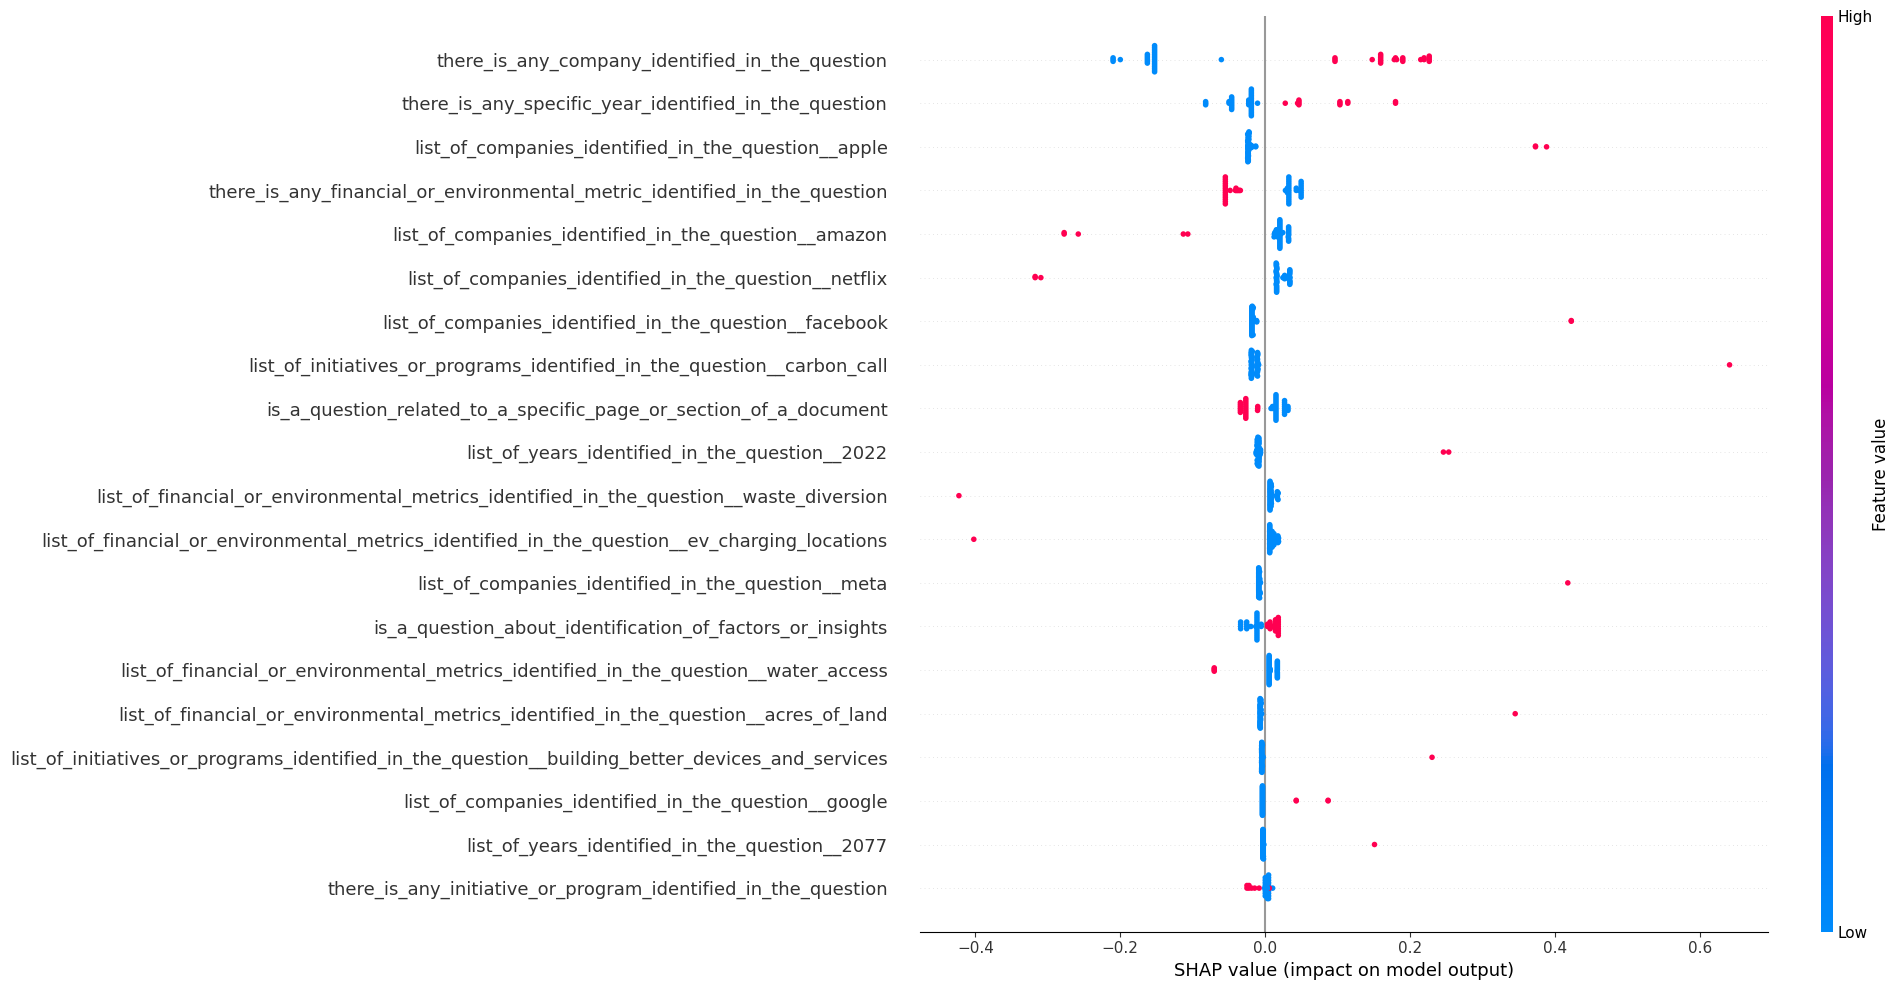

In [10]:
metric = 'context_recall'

X = pd.DataFrame(genai_explainer.preprocessed_features)
metric_explainer = genai_explainer.explainers_[metric]
shap_values = metric_explainer(X)
shap.summary_plot(shap_values, X, plot_size=(20,10))

In [11]:
df_metric = pd.DataFrame(genai_explainer.metrics)[[metric]]
df_metric['estimated_value'] = genai_explainer.estimators_[metric].predict(X)
df_metric['is_out_of_range'] = genai_explainer.is_out_of_range_[metric]

df_metric.style.apply(
    lambda s : [
        'background-color: yellow' if s.loc['is_out_of_range'] else '' for v in s.index
    ], axis=1)

,context_recall,estimated_value,is_out_of_range
0,0.000000,0.010975,False
1,0.000000,0.043611,False
2,0.000000,0.042109,False
3,1.000000,0.951786,False
4,1.000000,0.951374,False
5,0.000000,0.044316,False
6,0.000000,0.006281,False
7,0.000000,0.026930,False
8,0.000000,0.062519,False
9,0.000000,0.016907,False


In [12]:
index = 3

context = df_test_dataset.loc[index,'retrieved_contexts']
context_str = "\n".join([f"\n**CHUNK {i+1}:**\n\n{c}" for i, c in zip(range(len(context)),context)])


index_details = f"""
### INDEX {index}

**USER INPUT:**
{df_test_dataset.loc[index,'user_input']}

**RETRIEVED CONTEXT:**

{context_str}

**RESPONSE:**
{df_test_dataset.loc[index,'response']}

**REFERENCE:**
{df_test_dataset.loc[index,'reference']}

**METRIC:** {metric}

**METRIC Value:** {df_test_dataset.loc[index, metric]:.3f}

**MODEL ESTIMATED Value:** {df_metric.loc[index, 'estimated_value']:.3f}
"""

display(Markdown(index_details))


### INDEX 3

**USER INPUT:**
What was the listed key achievement regarding sustainbility and climate change for Google in 2077?

**RETRIEVED CONTEXT:**


**CHUNK 1:**

Our approach
We believe that every business has the opportunity and obligation to protect 
our planet. Sustainability is one of our core values at Google, and we strive  
to build sustainability into everything we do.
We’ve been a leader on sustainability and climate change since Google’s 
founding over 20 years ago. These are some of our key achievements over 
the past two decades:
2007:	We	became	the	first	major	company	to	be	carbon	neutral	for	our	operations.
2017:	We	became	the	first	major	company	to	match	100%	of	our	annual	electricity	
use	with	renewable	energy,			which	we’ve	achieved	for	five	consecutive	years.
2020:	We	issued	$5.75	billion	in	sustainability	bonds—the	largest	sustainability	 
or	green	bond	issuance	by	any	company	in	history	at	the	time.
2021:	We	matched	66%	of	our	data	center	electricity	use	with	regional 	 
carbon-free	sources,	on	an	hourly	basis.
Our sustainability strategy is focused on three key pillars: accelerating 
the transition to carbon-free energy and a circular economy, empowering 
everyone with technology, and benefiting the people and places where we 
operate (see Figure 1).
Figure	1	
SUSTAINABILITY STRATEGY OVERVIEW
We strive to build sustainability into everything we do
Empower	with	 
technology
Tackle major sustainability problems 
and drive net-positive impact using 
Google technologies, platforms, 
products, and services
Accelerate	carbon-free	 
and	circular	
Decouple business growth 
from the growth of carbon 
intensity and material use 
Benefit	people	 
and	places
Share benefits with the  
communities of our facilities,  
users, partners, and suppliers
2
Google Environmental Report 2022

**CHUNK 2:**

Empowering everyone with technology
To empower everyone with technology, we’ve committed to help 1 billion 
people make more sustainable choices by the end of 2022 through our core 
products. We introduced eco-friendly routing in Google Maps, new features 
to book flights or purchase appliances that have lower carbon footprints, 
and Nest Renew, a program to support clean energy from home. And when 
people come to Google Search with questions about climate change, we 
show information from authoritative sources like the United Nations.
Benefiting people and places
To benefit the people and places where we operate, we’ve set goals to 
replenish more water than we consume by 2030 and to support water security 
in communities where we operate. We’re focused on three areas: enhancing 
our stewardship of water resources across Google offices and data centers; 
replenishing our water use and improving watershed health and ecosystems 
in water-stressed communities; and sharing technology and tools that help 
everyone predict, prevent, and recover from water stress.
At Google, we remain steadfast in our commitment to sustainability, and we’ll 
continue to lead and encourage others to join us in improving the health of our 
planet. We’re proud of what we’ve achieved so far, and we’re energized to help 
move the world closer to a more sustainable and carbon-free future for all.
4
Google Environmental Report 2022

**RESPONSE:**
There is no listed key achievement for Google regarding sustainability and climate change in the year 2077.

**REFERENCE:**
In 2017, Google became the first major company to match 100% of their annual electricity use with renewable energy, which they've achieved for five consecutive years.

**METRIC:** context_recall

**METRIC Value:** 1.000

**MODEL ESTIMATED Value:** 0.952


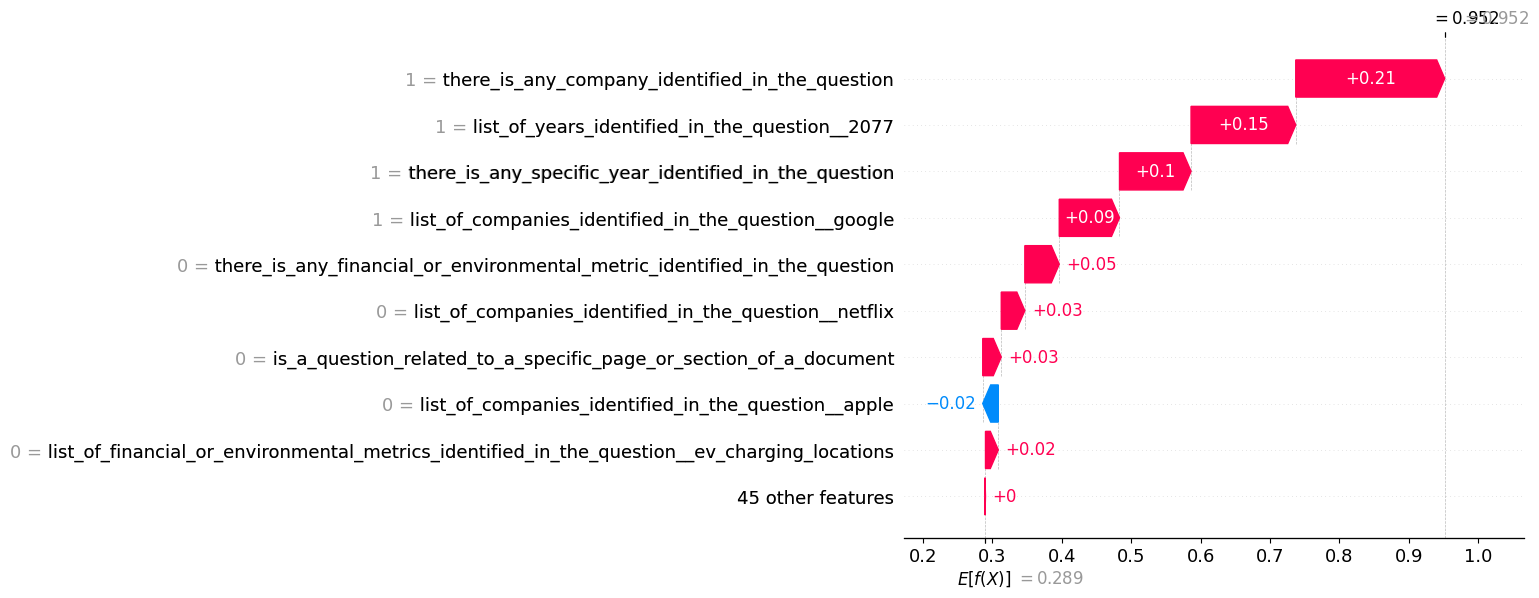

In [13]:
shap.waterfall_plot(shap_values[index])